In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import subpixellayer as sl # Is important for the subpixel layer
import utilities as u

from keras.models import load_model
from pathlib import Path

# Surpress warnings related to NaNs
from warnings import filterwarnings
filterwarnings('ignore')

# Turn off Tensorflow Logs and other tensorflow options
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

In [2]:
# Model directory / Network architecture
model_dir = "OriginalFukami"

# Additional run info
sample_num = 11400  # Try 17285 for a badly reconstructed example

variables = ["Hs", "Tm02", "Dir"]
convert = True # Is Direction data to be shifted? 
nan_thresholds = [0.1, 0.5, 0.5] # Under which value should be regarded as NaN?

# Save the figure?
save = False

# Load models into list
models = []
LRs = []
HRs = []

for var in variables:
    # Load models
    fdir = Path(f"Models/{model_dir}")
    fmodel = fdir / f"Model_Inp_{var}.hdf5"
    models.append(load_model(fmodel))

    # Load LR - Data and reference
    fn_LR = f"Data/Examples/LR/{var}/BaskCoast_{var.upper()}_{sample_num}.npy"
    LRs.append(np.load(fn_LR))

    fn_HR = f"Data/Examples/HR/{var}/BaskCoast_{var.upper()}_{sample_num}.npy"
    HRs.append(np.load(fn_HR))

In [3]:
predictions = []
maes = []
for i, LR in enumerate(LRs):
    # Check if direction variable should be shifted
    if variables[i] == "Dir" and convert:
        # Convert NaNs to zero for prediction with the neural network
        LR_inp = np.nan_to_num((LR + 105)%360)
        # Predict with the neural network and set negligible values back to NaN
        prediction = models[i].predict(np.reshape(LR_inp, (1, 10, 10, 1)))
        # Squeeze unnecessary axes for plotting
        prediction = np.squeeze(prediction)
        prediction[prediction < nan_thresholds[i]] = np.nan
        prediction = (prediction + 255)%360
    else:
        LR_inp = np.nan_to_num(LR)
        prediction = models[i].predict(np.reshape(LR_inp, (1, 10, 10, 1)))
        # Squeeze unnecessary axes for plotting
        prediction = np.squeeze(prediction)
        prediction[prediction < nan_thresholds[i]] = np.nan
    
    # Upsample LR image for the plot 
    LRs[i] = u.NNUpsampling(LR, factor=16)
    
    # Store all predictions in one list
    predictions.append(prediction)
    
    # Compute MAE per image
    maes.append(np.nanmean((HRs[i] - prediction)))
    
data = [LRs, predictions, HRs]
diffs = [HRs[i] - predictions[i] for i in range(3)]

1/1 [==============================] - 0s 198ms/step


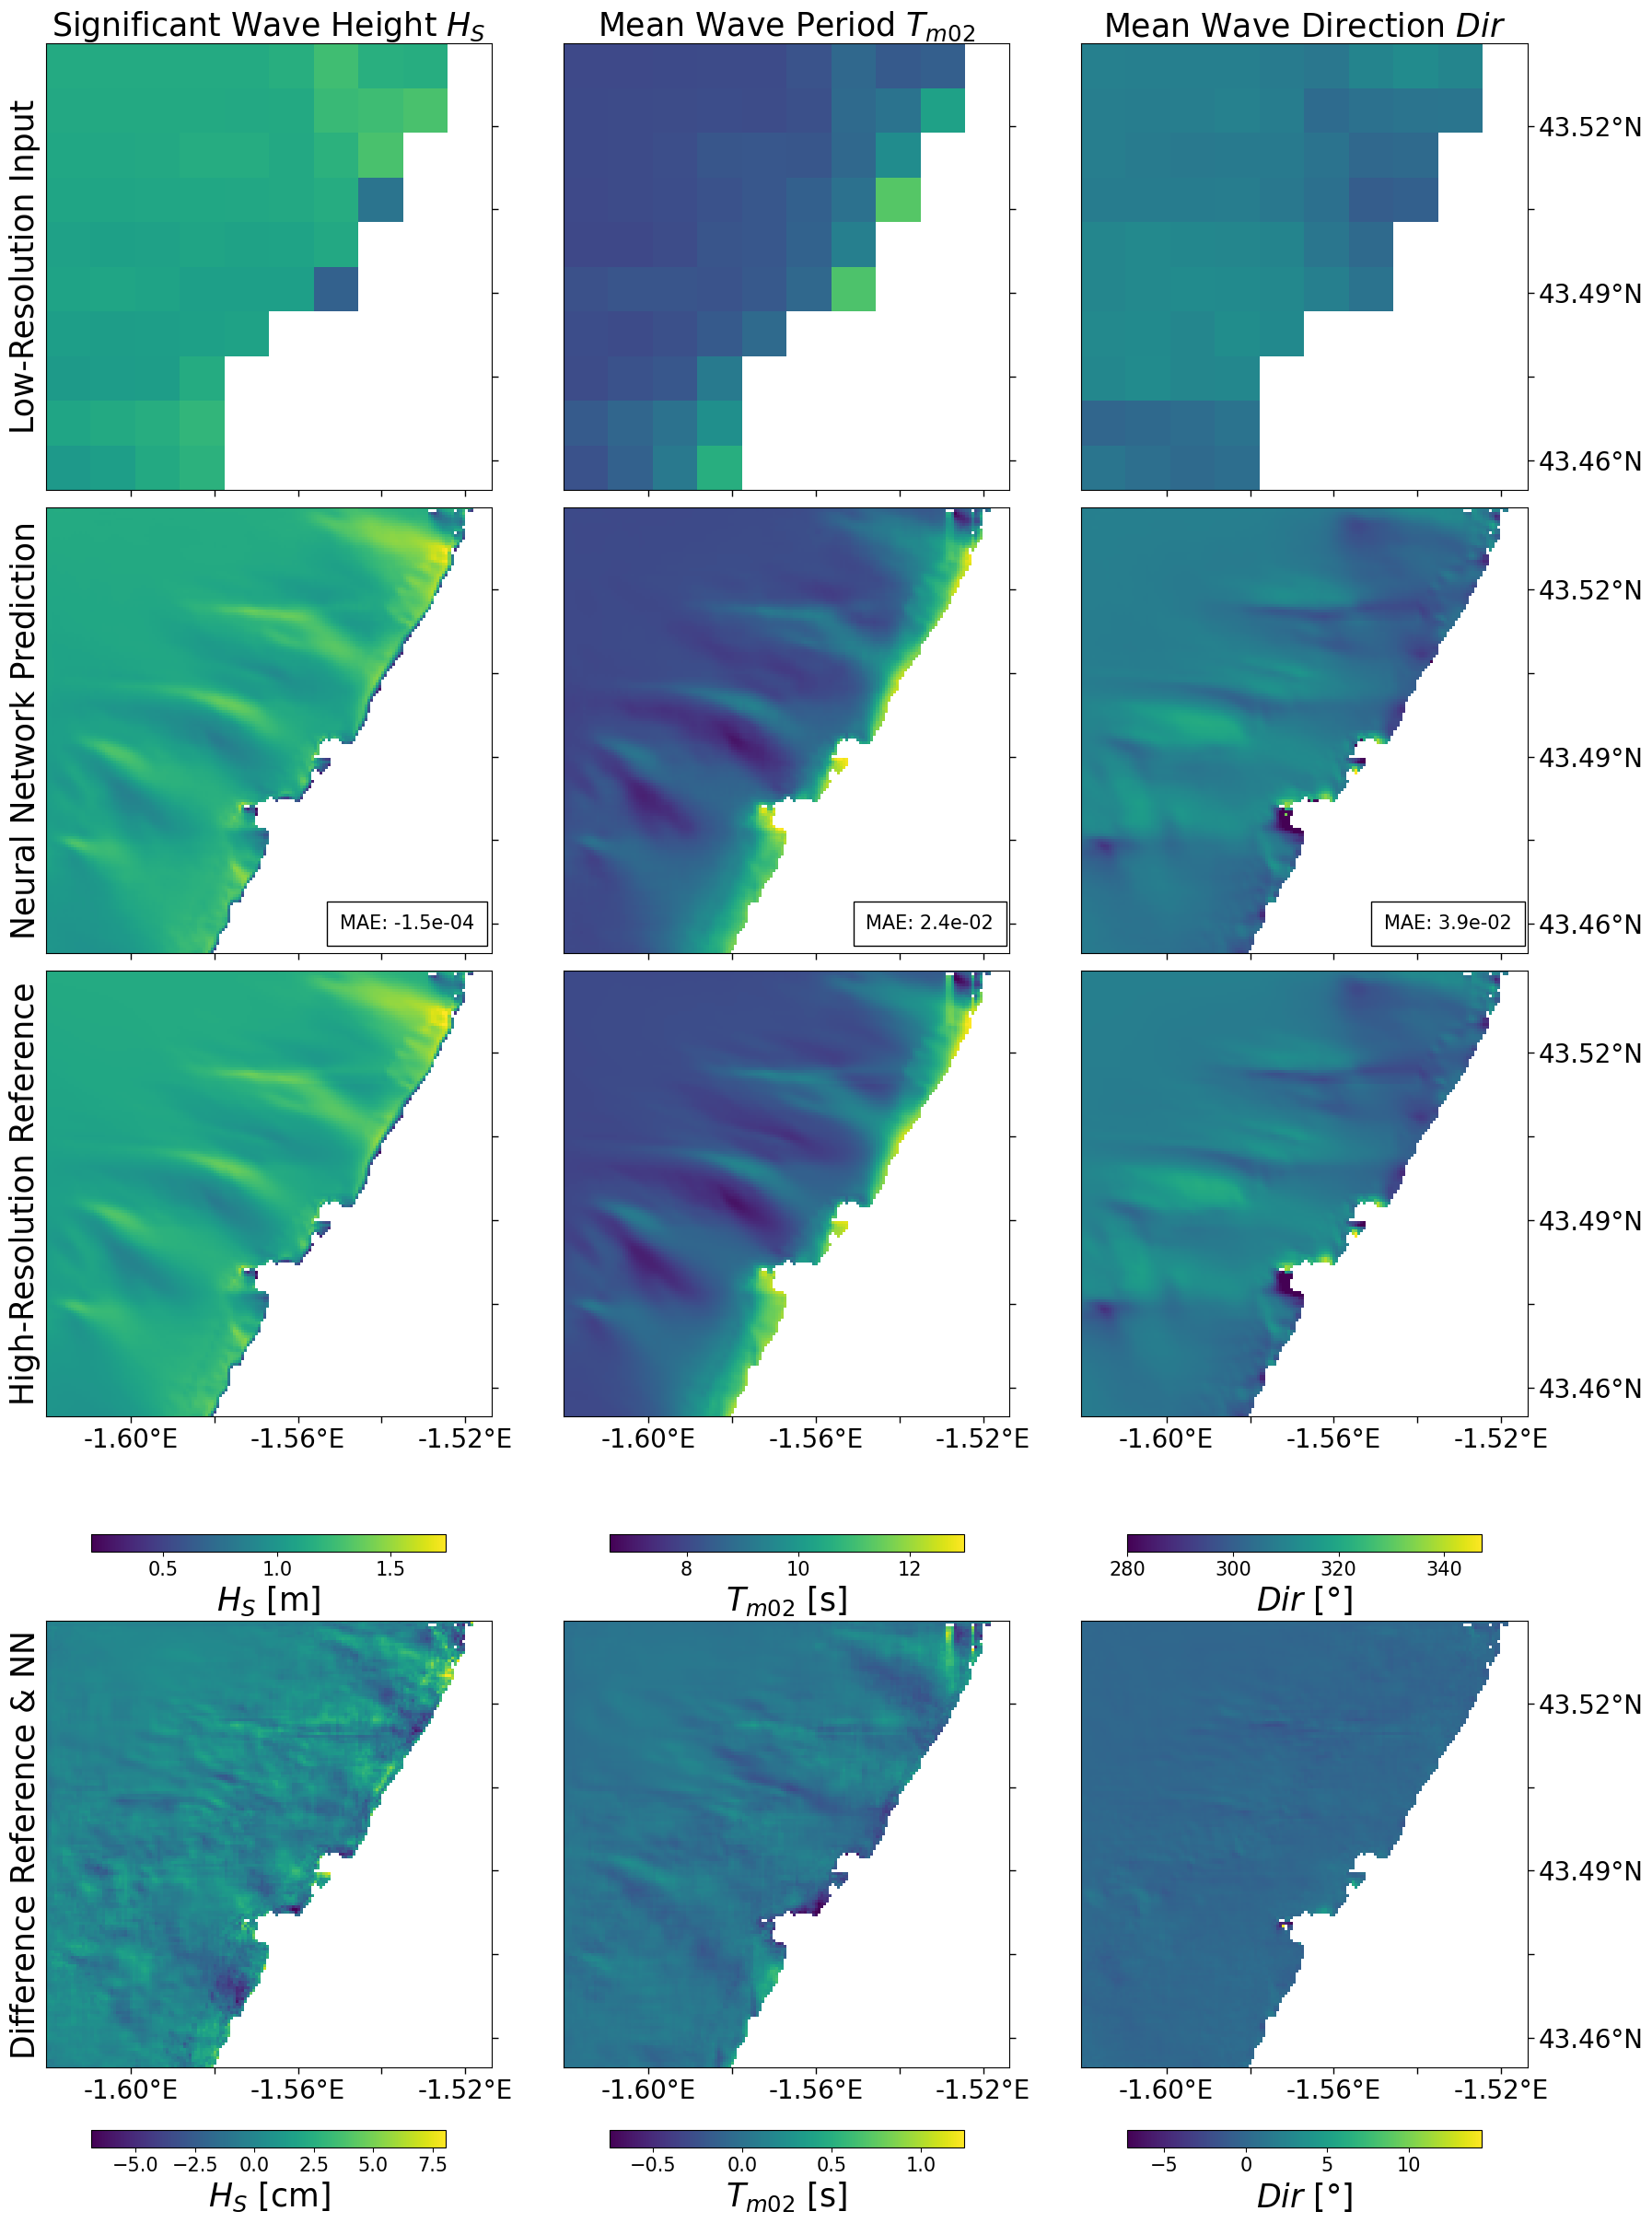

In [5]:
# Define the ranges of longitude and latitude to set up the coordinate system
minlon = -1.617
maxlon = -1.518

minlat = 43.46
maxlat = 43.53


# Format coordinates in a pretty way
x = ["-1.60°E", "", "-1.56°E", "", "-1.52°E"]
y = ["43.46°N", "", "43.49°N", "", "43.52°N"]

# Get the position of the ticks
x_loc = np.arange(30, 160, 30)
y_loc = np.arange(10, 160, 30)


vmin0 = np.nanmin(predictions[0])
vmax0 = np.nanmax(predictions[0])

vmin1 = np.nanmin(predictions[1])
vmax1 = np.nanmax(predictions[1])

vmin2 = 280
vmax2 = np.nanmax(predictions[2])

# Some plotting constants for the ticks
LABELSIZE = 20
LENGTH = 5.0
WIDTH= 1.0
CBAR_LABELSIZE = 15

# Colorbar Properties
CB_BOTTOM = 0.05
CB_WIDTH = 0.25
CB_HEIGHT = 0.01
CB_LEFT0 = 0.04
CB_LEFT1 = 0.35
CB_LEFT2 = 0.67

# Scale colorbars by this factor
SHRINK = 0.7

cmap = "viridis"

fig, axs = plt.subplots(4, 3, figsize=(18,24), constrained_layout=True)
plt.rc('axes', labelsize=25) 
plt.rc('axes', titlesize=25)

############################# First Row

axs[0,0].imshow(LRs[0], cmap=cmap, origin="lower", vmin=vmin0, vmax=vmax0)
axs[0,0].set_ylabel("Low-Resolution Input")
axs[0,0].set_title(r"Significant Wave Height $H_S$")
axs[0,0].set_xticks(x_loc)
axs[0,0].set_yticks(y_loc)
axs[0,0].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
axs[0,0].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)

axs[0,1].imshow(LRs[1], cmap=cmap, origin="lower", vmin=vmin1, vmax=vmax1)
axs[0,1].set_title(r"Mean Wave Period $T_{m02}$")
axs[0,1].set_xticks(x_loc)
axs[0,1].set_yticks(y_loc)
axs[0,1].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
axs[1,0].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)

axs[0,2].imshow(LRs[2], cmap=cmap, origin="lower", vmin=vmin2, vmax=vmax2)
axs[0,2].set_title(r"Mean Wave Direction $Dir$")
axs[0,2].set_xticks(x_loc)
axs[0,2].set_yticks(y_loc)
axs[0,2].set_yticklabels(y)
axs[0,2].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=False)
axs[0,2].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)



############################ Second Row


pos0 = axs[1,0].imshow(predictions[0], cmap=cmap, origin="lower", vmin=vmin0, vmax=vmax0)
axs[1,0].text(105, 8, 'MAE: {:.1e}'.format(maes[0]), bbox={'facecolor': 'white', 'pad': 10}, fontdict={'size': 15})
axs[1,0].set_ylabel("Neural Network Prediction")
axs[1,0].set_xticks(x_loc)
axs[1,0].set_yticks(y_loc)
axs[1,0].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
axs[0,1].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


pos1 = axs[1,1].imshow(predictions[1], cmap=cmap, origin="lower", vmin=vmin1, vmax=vmax1)
axs[1,1].text(108, 8, 'MAE: {:.1e}'.format(maes[1]), bbox={'facecolor': 'white', 'pad': 10}, fontdict={'size': 15})
axs[1,1].set_xticks(x_loc)
axs[1,1].set_yticks(y_loc)
axs[1,1].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
axs[1,1].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


pos2 = axs[1,2].imshow(predictions[2], cmap=cmap, origin="lower", vmin=vmin2, vmax=vmax2)
axs[1,2].text(108, 8, 'MAE: {:.1e}'.format(maes[2]), bbox={'facecolor': 'white', 'pad': 10}, fontdict={'size': 15})
axs[1,2].set_xticks(x_loc)
axs[1,2].set_yticks(y_loc)
axs[1,2].set_yticklabels(y)
axs[1,2].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=False)
axs[1,2].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)



############################ Third Row


axs[2,0].imshow(HRs[0], cmap=cmap, origin="lower", vmin=vmin0, vmax=vmax0)
axs[2,0].set_xticks(x_loc)
axs[2,0].set_xticklabels(x)
axs[2,0].set_yticks(y_loc)
axs[2,0].set_ylabel("High-Resolution Reference")
axs[2,0].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=True)
axs[2,0].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)

cbar = fig.colorbar(pos0, ax=axs[:3,0], orientation="horizontal", label=r"$H_S$ [m]",
             pad=0.05, shrink=SHRINK)
cbar.ax.tick_params(labelsize=15)

axs[2,1].imshow(HRs[1], cmap=cmap, origin="lower", vmin=vmin1, vmax=vmax1)
axs[2,1].set_xticks(x_loc)
axs[2,1].set_xticklabels(x)
axs[2,1].set_yticks(y_loc)
axs[2,1].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=True)
axs[2,1].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)

cbar = fig.colorbar(pos1, ax=axs[:3,1], orientation="horizontal", label=r"$T_{m02}$ [s]", shrink=SHRINK)
cbar.ax.tick_params(labelsize=15)

axs[2,2].imshow(HRs[2], cmap=cmap, origin="lower", vmin=vmin2, vmax=vmax2)
axs[2,2].set_xticks(x_loc)
axs[2,2].set_xticklabels(x)
axs[2,2].set_yticks(y_loc)
axs[2,2].set_yticklabels(y)
axs[2,2].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=True)
axs[2,2].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


cbar = fig.colorbar(pos2, ax=axs[:3,2], orientation="horizontal", label=r"$Dir$ [°]", shrink=SHRINK)
cbar.ax.tick_params(labelsize=15)

####################### Fourth Row (Difference maps)
pos3 = axs[3,0].imshow((HRs[0] - predictions[0])*100, cmap=cmap, origin="lower")
axs[3,0].set_xticks(x_loc)
axs[3,0].set_xticklabels(x)
axs[3,0].set_yticks(y_loc)
axs[3,0].set_ylabel("Difference Reference & NN")
axs[3,0].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=True)
axs[3,0].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


cbar = fig.colorbar(pos3, ax=[axs[3,0]], orientation="horizontal", label=r"$H_S$ [cm]", shrink=SHRINK)
cbar.ax.tick_params(labelsize=15)


pos4 = axs[3,1].imshow(HRs[1] - predictions[1], cmap=cmap, origin="lower")
axs[3,1].set_xticks(x_loc)
axs[3,1].set_xticklabels(x)
axs[3,1].set_yticks(y_loc)
axs[3,1].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                    labelleft=False, labeltop=False, labelright=False, labelbottom=True)
axs[3,1].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)

cbar = fig.colorbar(pos4, ax=[axs[3,1]], orientation="horizontal", label=r"$T_{m02}$ [s]", shrink=SHRINK)
cbar.ax.tick_params(labelsize=15)

diff = HRs[2] - predictions[2]
diff[np.abs(diff) > 50] = np.nan
pos5 = axs[3,2].imshow(diff, cmap=cmap, origin="lower")
axs[3,2].set_xticks(x_loc)
axs[3,2].set_xticklabels(x)
axs[3,2].set_yticks(y_loc)
axs[3,2].set_yticklabels(y)
axs[3,2].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=True)
axs[3,2].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


cbar = fig.colorbar(pos5, ax=[axs[3,2]], orientation="horizontal", label=r"$Dir$ [°]", shrink=SHRINK)
cbar.ax.tick_params(labelsize=15)



fdir = Path("Plots")
fname = f"MainPlot_{var}_Mod_{model_dir}_DS_{sample_num}.png"

if save:
    if not os.path.isdir(fdir):
        os.makedirs(fdir)
    plt.savefig(os.path.join(fdir, fname))
                         
plt.show()